In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def _expandRect(img, rect, expand_size=128):
    """Expands the bounding box (rectangle) around the nuclei

    it aims to expand the bounding box to a square, to be used as
    input for a neural network.

    if expanded bounding box reaches an edge, the remaining expansion
    goes in the oposite direction
    """
    x, y, w, h = rect
    w_neg, w_pos = int(np.floor((expand_size-w)/2)), int(np.ceil((expand_size-w)/2))
    h_neg, h_pos = int(np.floor((expand_size-h)/2)), int(np.ceil((expand_size-h)/2))

    y_from_edge_top = y-h_neg
    if y_from_edge_top < 0:
        y_dist_from_edge_top = np.absolute(y_from_edge_top)
    else:
        y_dist_from_edge_top = 0

    y_from_edge_bottom = y+h+h_pos
    if y_from_edge_bottom > img.shape[0]:
        y_dist_from_edge_bottom = y_from_edge_bottom-img.shape[0]
    else:
        y_dist_from_edge_bottom = 0

    x_from_edge_left = x-w_neg
    if x_from_edge_left < 0:
        x_dist_from_edge_left = np.absolute(x_from_edge_left)
    else:
        x_dist_from_edge_left = 0

    x_from_edge_right = x+w+w_pos
    if x_from_edge_right > img.shape[1]:
        x_dist_from_edge_right = x_from_edge_right-img.shape[1]
    else:
        x_dist_from_edge_right = 0

    w_neg = w_neg - x_dist_from_edge_left   + x_dist_from_edge_right
    w_pos = w_pos - x_dist_from_edge_right  + x_dist_from_edge_left
    h_neg = h_neg - y_dist_from_edge_top    + y_dist_from_edge_bottom
    h_pos = h_pos - y_dist_from_edge_bottom + y_dist_from_edge_top

    return w_neg, w_pos, h_neg, h_pos


def _NCratio(binary_img):
    """Rough approximation of the nucleus-cytoplasm ratio
            Used to expand the bounding box around the nuclei
            to capture approximately a whole cell
    """
    return (binary_img[:,:,2].sum()+binary_img[:,:,3].sum())/binary_img[:,:,2].sum()


def binarizeImage(img, filter_size=8):
    """Binarizes the image based on OTSU:
            (1) Image is first passed through a Gaussian filter,
            (2) then thresholded with the OTSU thresholding

    Outputs a binarized version of the original image
    """

    binary_image = np.empty(img.shape)
    for i in range(img.shape[-1]):
        image_blurred = cv2.GaussianBlur(img[:,:,i], (11,11), 0)
        threshold,_   = cv2.threshold(image_blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        binary_image[:,:,i] = (image_blurred > threshold)

    return binary_image

def cellCropping(binary_image, image, only_whole_nuclei=True, box_size_window=(30,90)):
    """This function generates cropped images
    together with the helper functions above.

    Inputs:
        Binary image (4-D)
        Original image (4-D)
        only_whole_nuclei (which should be True)
        box_size_window (min width/height and max width/height in a tuple)
    Outputs:
        List of cropped images
    """

    binary_blue = binary_image[:,:,2].astype('uint8')

    contours = cv2.findContours(binary_blue, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    cropped_images = []
    for contour in contours[1]:
        # obtaining the bounding rectangle
        rect = cv2.boundingRect(contour)
        x, y, w, h = rect

        if box_size_window:
            if box_size_window[0] > max(h, w) or box_size_window[1] < min(h, w): continue

        # root squared is used below because the variable 'box_size'
        # should be the side (thus a scalar) of the rect.
        box_size = max(w, h)*np.sqrt(_NCratio(binary_image))

        if only_whole_nuclei == True:
            if all( [x != 0, y != 0, x+w < binary_blue.shape[0], y+h < binary_blue.shape[1]] ):
                w_neg, w_pos, h_neg, h_pos = _expandRect(binary_blue, rect, expand_size=int(box_size))
            else: continue
        else:
            w_neg, w_pos, h_neg, h_pos = _expandRect(binary_blue, rect, expand_size=int(box_size))

        # Make sure that the cropped image is actually the box size we want before we append it.
        if ((y+h+h_pos)-(y-h_neg), (x+w+w_pos)-(x-w_neg)) == (int(box_size), int(box_size)):
            cropped_images.append(image[y-h_neg:y+h+h_pos, x-w_neg:x+w+w_pos, :])

    return cropped_images


image_name = "Test-image-1"
# image_name = "Test-image-2"
# image_name = "Test-image-3"

red     = cv2.imread("images/{}_red.png".format(image_name), 0)
blue    = cv2.imread("images/{}_blue.png".format(image_name), 0)
green   = cv2.imread("images/{}_green.png".format(image_name), 0)
yellow  = cv2.imread("images/{}_yellow.png".format(image_name), 0)
RGBY_image = np.dstack((red, green, blue, yellow))

binary_image   = binarizeImage(RGBY_image)
cropped_images = cellCropping(binary_image=binary_image, image=RGBY_image, box_size_window=(30,90))
print("{} Images were cropped from the original image".format(len(cropped_images)))


10 Images were cropped from the original image


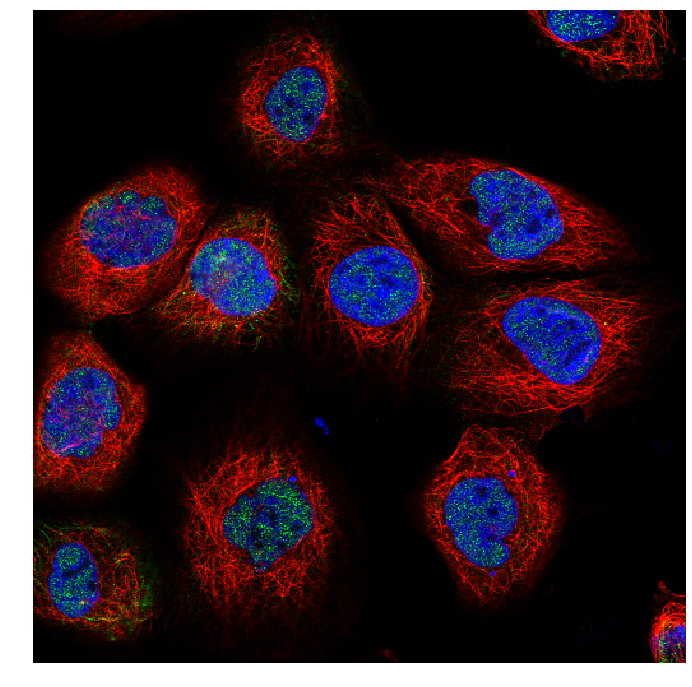

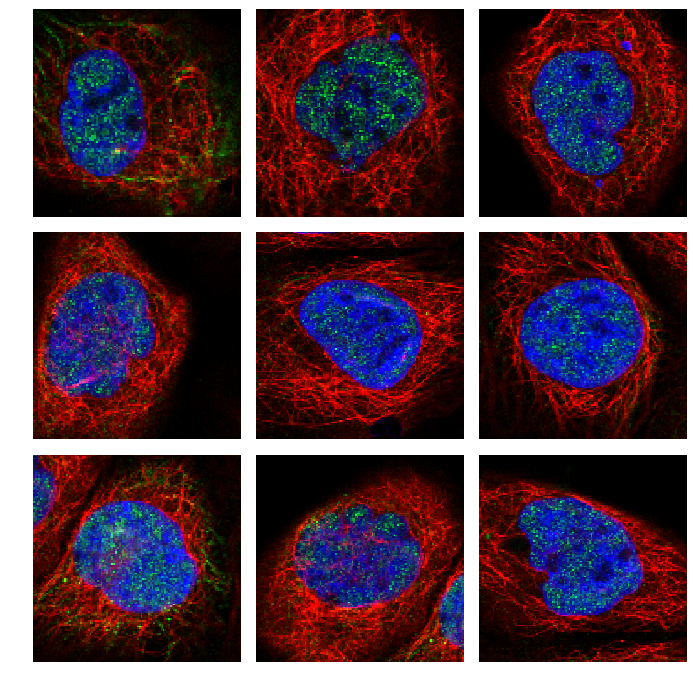

In [3]:
# Plots original image
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(RGBY_image[:,:,:3]);

# Plots cropped images of the original image
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=3)
axes = axes.flat

for i, ax in enumerate(axes):
    ax.imshow(cropped_images[i][:,:,:3])
    ax.axis('off')

fig.subplots_adjust(wspace=0, hspace=0.075)